In [1]:
from schrodinger_box.schrodinger_box import Schrodinger1DTimeDependentPINN, LossTDSE1D, LossInitialConditionTDSE1D
from core.neural_network import FeedForwardNN
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
L = 1.0 # Length of box

In [5]:
from schrodinger_box.tise1d_box import PINN, Loss_PDE, Loss_Norm, Loss_Orthogonality, ansatzfactor, ansatzfactor_n2
from core.interfaces import PhysicsLoss

def train_box_example(
        loss_func: PhysicsLoss,
        L = 1.0,
        hidden_layers = 3,
        width = 32,
        lr: float = 1e-2,
        n_epochs: int = 3000,
        n_samples: int = 256,
        device = "cuda" if torch.cuda.is_available() else "cpu",
        ansatz_factor = ansatzfactor
    ):

    #Build the model
    model = FeedForwardNN(
        in_dim=1,
        out_dim=1,
        hidden_layers=hidden_layers,
        width=width,
        activation_func=nn.Tanh,
    ).to(device)
    pinn = PINN(model, ansatz_factor, L=L).to(device)

    # Optimizer
    optimizer = torch.optim.Adam(pinn.parameters(), lr=lr, weight_decay=0.0) # No weight decay for now

    input = torch.linspace(0,L, n_samples).view(-1, 1).to(device)

    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        loss = loss_func(pinn, input)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.6e}")
            
    return pinn
    

In [6]:
def psi_analytic(x, L, n=1):
    return torch.sqrt(torch.tensor(2.0/L)) * torch.sin(n * torch.pi * x / L)

def energy_analytic(L, n=1):
    hbar = 1.0
    m = 1.0
    return (n**2 * torch.pi**2 * hbar**2) / (2 * m * L**2)

def compare_analytic(x, L, pinn, n=1):
    with torch.no_grad():
        psi_pred = pinn(x.to(device)).cpu()
    psi_exact = psi_analytic(x, L, n).cpu()

    # Compute inner product (discrete)
    overlap = torch.sum(psi_pred * psi_exact)
    # If overlap negative → flip predicted sign
    if overlap < 0:
        psi_pred = -psi_pred

    energy_pred = pinn.E
    energy_exact = energy_analytic(L, n)
    rel_error = torch.abs((energy_pred - energy_exact) / energy_exact)
    print(f"Predicted Energy: {energy_pred.item():.6f}, Exact Energy: {energy_exact:.6f}, Relative Error: {rel_error:.6%}")
    
    
    plt.plot(x.numpy(), psi_pred.numpy(), label='PINN Prediction')
    plt.plot(x.numpy(), psi_exact.numpy(), label='Analytic Solution', linestyle='dashed')
    plt.xlabel('x')
    plt.ylabel('ψ(x)')
    plt.title('Comparison of PINN and Analytic Solution')
    plt.legend()
    plt.show()

In [7]:
pinn1 = train_box_example(
    loss_func = Loss_PDE() + 100*Loss_Norm(),
    L=L,
)

Epoch 100/3000, Loss: 1.669226e+01
Epoch 200/3000, Loss: 1.169455e+01
Epoch 300/3000, Loss: 8.528132e+00
Epoch 400/3000, Loss: 6.705078e+00
Epoch 500/3000, Loss: 5.761547e+00
Epoch 600/3000, Loss: 5.325477e+00
Epoch 700/3000, Loss: 4.387120e+00
Epoch 800/3000, Loss: 2.786240e+00
Epoch 900/3000, Loss: 2.701037e+00
Epoch 1000/3000, Loss: 2.685307e+00
Epoch 1100/3000, Loss: 2.623701e+00
Epoch 1200/3000, Loss: 2.577116e+00
Epoch 1300/3000, Loss: 2.570470e+00
Epoch 1400/3000, Loss: 2.568063e+00
Epoch 1500/3000, Loss: 2.566604e+00
Epoch 1600/3000, Loss: 2.565454e+00
Epoch 1700/3000, Loss: 2.564484e+00
Epoch 1800/3000, Loss: 2.563815e+00
Epoch 1900/3000, Loss: 2.562708e+00
Epoch 2000/3000, Loss: 1.126606e-01
Epoch 2100/3000, Loss: 2.138155e-02
Epoch 2200/3000, Loss: 7.463506e-03
Epoch 2300/3000, Loss: 2.529624e-03
Epoch 2400/3000, Loss: 2.165386e-03
Epoch 2500/3000, Loss: 5.448725e-04
Epoch 2600/3000, Loss: 1.940675e-03
Epoch 2700/3000, Loss: 2.891941e-04
Epoch 2800/3000, Loss: 2.361446e-04
E

In [8]:
# Freeze
pinn1.eval()  # freeze behavior
for p in pinn1.parameters():
    p.requires_grad_(False)


Predicted Energy: 4.934807, Exact Energy: 4.934802, Relative Error: 0.000106%


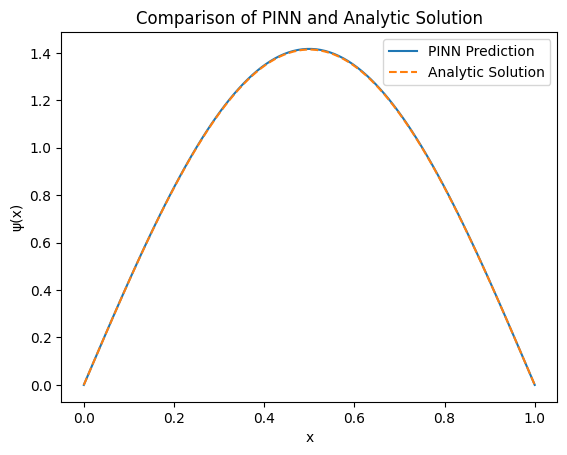

In [9]:
x_test = torch.linspace(0, L, 100).view(-1, 1).to(device)
compare_analytic(x_test, L, pinn1)